<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-17.1" data-toc-modified-id="Figure-17.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 17.1</a></span></li><li><span><a href="#Figure-17.2" data-toc-modified-id="Figure-17.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 17.2</a></span></li><li><span><a href="#Figure-16.2" data-toc-modified-id="Figure-16.2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 16.2</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 17
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal as sig

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 17.1

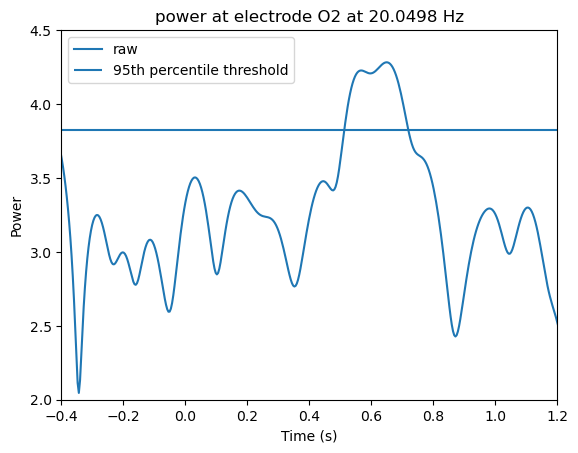

In [4]:
num_frex = 6
frex = np.logspace(np.log10(4),np.log10(30),num_frex)
s = 6/(2*np.pi*frex)
time = np.arange(-1,1 + 1/srate,1/srate)

# note that you don't need the wavelet itself, you need the FFT of the wavelet
mwaves = np.zeros([num_frex,len(time)]) * 1j
swaves = np.zeros([num_frex,len(time)]) * 1j

for fi in range(num_frex):
    # Create Morlet wavelets and s-transforms. Note that scaling factors
    # are omitted to focus on the shape of the function.
    mwaves[fi,:] = np.exp(2*1j*np.pi*frex[fi]*time) * np.exp(-time**2/(2*s[fi]**2))
    swaves[fi,:] = np.exp(2*1j*np.pi*frex[fi]*time) * np.exp(-time**2 * frex[fi]**2 / 2)
    
time = np.arange(-1,1+ 1/srate,1/srate)
n_wavelet = len(time)
n_data = pnts * trials
n_conv = n_wavelet + n_data - 1
half_wave = (len(time))//2

eegfft = np.fft.fft(np.reshape(data[:, 63,:],[1,pnts*trials]),n_conv)

#convolution
eegconv = np.fft.ifft(np.fft.fft(mwaves[4,:],n_conv)*eegfft)
eegconv = eegconv[0,half_wave:-half_wave]

#reshape to time X trials
eegpower = np.log10(np.abs(np.reshape(eegconv,[pnts,trials], order='F'))**2)

plt.plot(times,eegpower[:,49])
threshold = np.percentile(eegpower[:],95)
plt.hlines(threshold,-.4,1.2)
plt.legend(["raw","95th percentile threshold"])
channel = chan_labels[63]
_=plt.setp(plt.gca(), 'xlim', [-.4,1.2], 'ylim', [2,4.5], 'xlabel', 'Time (s)', 'ylabel', 'Power', 'title', "power at electrode " + channel + " at " + str(np.round(frex[4], 4)) + " Hz")

## Figure 17.2

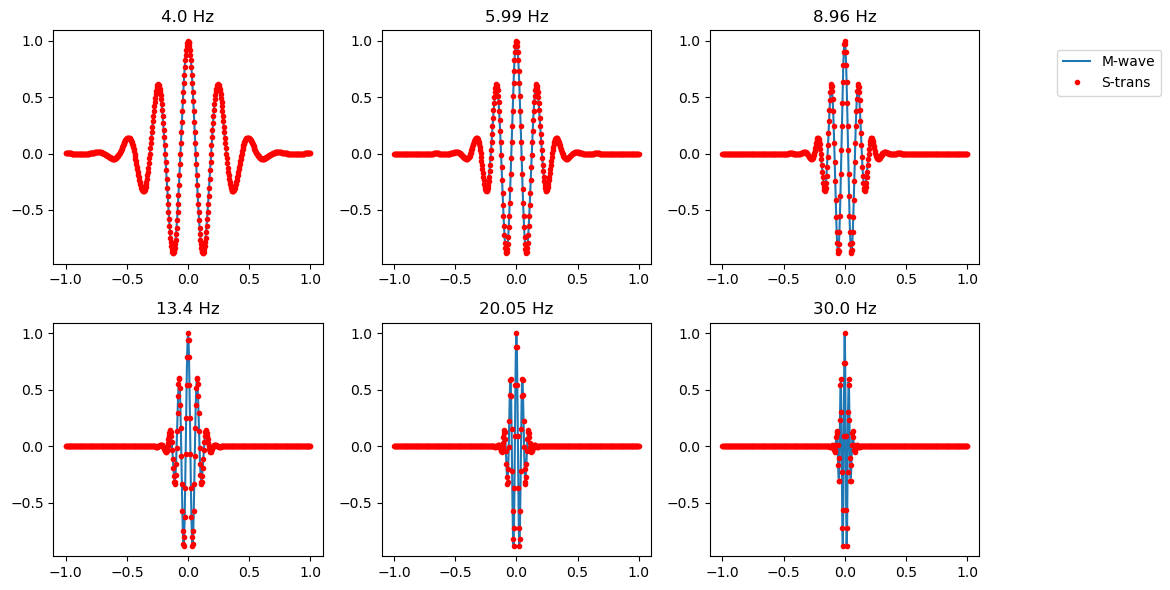

In [5]:
fig=plt.figure(figsize=(10,6))
for i in range(num_frex):
    plt.subplot(2,3,i+1)
    plt.plot(time,np.real(mwaves[i,:]))
    plt.plot(time,np.real(swaves[i,:]),'r.')
    plt.title(str(np.round(frex[i],2)) + " Hz")

plt.tight_layout()
_=plt.legend(["M-wave","S-trans"], bbox_to_anchor=[1.7,2.2])